In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from modules.xG_constants import *
from modules.xG_preprocessing import Preprocessing
from modules.xG_visualization import Visualization
from modules.xG_models import ModelTrainer
from modules.xG_evaluation import ModelEvaluation

In [2]:
import os
os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'

# Then create SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("xG_timeline") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.driver.extraLibraryPath", os.environ["HADOOP_COMMON_LIB_NATIVE_DIR"]) \
    .config("spark.executor.extraLibraryPath", os.environ["HADOOP_COMMON_LIB_NATIVE_DIR"]) \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/01 00:13:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
PL = spark.read.csv('Dataset/events/England - Premier League.csv', inferSchema=True, header=True, sep=';')

In [7]:
PL = Preprocessing(spark, PL)

25/06/06 08:40:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [21]:
PL_train_data, PL_test_data = PL.data_split(train_size=0.99)

In [23]:
PL_dt = ModelTrainer(PL_train_data, PL_train_data) # Default is Logistic Regression

In [ ]:
from pyspark.sql.window import Window
import numpy as np
import pandas as pd

def get_match_id(df,
                 match_id):

    if match_id is not None:
        df = df.filter(F.col('match_id') == match_id)
        if df.limit(1).count() == 0:
            raise ValueError("No data available for the given match_id.")
    else:
        random_match_id = df.select("match_id").orderBy(F.rand()).limit(1).collect()[0]["match_id"]
        df = df.filter(F.col('match_id') == random_match_id)
    return df

def xG_timeline(df,
                match_id : int | None = None,
                xg_col : str = 'shot_statsbomb_xg',
                columns : list[str] = CUMULATIVE_XG_COLUMNS):
    
    df = get_match_id(df, match_id)
    
    window_spec = Window.partitionBy('match_id', 'team') \
                        .orderBy('minute', 'second') \
                        .rowsBetween(Window.unboundedPreceding,
                                     Window.currentRow)

    df = df.withColumn()

In [27]:
from pyspark.sql.window import Window
import numpy as np
import pandas as pd

def get_match_id(df, match_id):
    if match_id is not None:
        df = df.filter(F.col('match_id') == match_id)
        if df.limit(1).count() == 0:
            raise ValueError("No data available for the given match_id.")
    else:
        random_match_id = df.select("match_id").orderBy(F.rand()).limit(1).collect()[0]["match_id"]
        df = df.filter(F.col('match_id') == random_match_id)
    return df

def xG_timeline(df,
                match_id : int | None = None,
                columns : list[str] = CUMULATIVE_XG_COLUMNS):
    
    df = get_match_id(df, match_id)
    
    window_spec = Window.partitionBy('match_id', 'team') \
                        .orderBy('minute', 'second') \
                        .rowsBetween(Window.unboundedPreceding,
                                     Window.currentRow)

    df = df.withColumn('sb_CxG',
                        F.sum('shot_statsbomb_xg').over(window_spec)) \
           .withColumn('CxG',
                        F.sum('xG').over(window_spec))

    df_p = df.select(columns).orderBy('minute', 'second').toPandas()

    teams = df_p[~df_p['team'].isna()]['team'].unique()

    i = 92 if df_p['minute'].max() < 90 else df_p['minute'].max() + 2

    mins_range = np.arange(0, i)
    sec_range = np.arange(0, 60)

    ft = pd.DataFrame([(m, s) for m in mins_range for s in sec_range], columns=['minute', 'second'])

    max_sb = max_cxg = 1

    fig, (ax1, ax2) = plt.subplots(ncols=2,
                                    nrows=1,
                                    figsize=(14, 7))

    for team in teams:
        df_team = df_p[df_p['team'] == team]

        df_team = ft.merge(df_team,
                            on=('minute', 'second'),
                            how='left')

        df_team['sb_CxG'] = df_team['sb_CxG'].ffill().fillna(0)
        df_team['CxG'] = df_team['CxG'].ffill().fillna(0)
        df_team['goal'] = df_team['goal'].fillna(0).astype(int)
        
        df_team['time'] = df_team['minute'] + round(df_team['second'] / 60, 2)
        
        max_sb = max(max_sb, df_team['sb_CxG'].max())
        max_cxg = max(max_cxg, df_team['CxG'].max())
        
        ax1.plot(df_team['time'],
                    df_team['sb_CxG'],
                    label=team)
        ax1.scatter(df_team[df_team['goal'] == 1]['time'],
                    df_team[df_team['goal'] == 1]['sb_CxG'])
        
        ax2.plot(df_team['time'],
                    df_team['CxG'],
                    label=team)
        ax2.scatter(df_team[df_team['goal'] == 1]['time'],
                    df_team[df_team['goal'] == 1]['CxG'])

    max_y = max(max_sb, max_cxg)

    for ax in [ax1, ax2]:
        ax.axvline(x=45,
                    color='black',
                    linestyle='--')
        ax.set_xticks([15, 30, 45, 60, 75, 90])

        ax.set_xlim(0, i - 1)
        ax.set_ylim(0, max_y + 0.3)

        ax.legend(loc='upper left')
        ax.set_xlabel('Minutes')

    ax1.set_ylabel('statsbomb xG')
    ax1.set_title('Statsbomb xG Cumulative Timeline')
    ax2.set_ylabel('xG')
    ax2.set_title('Predicted xG Cumulative Timeline')

    plt.tight_layout()
    plt.show()

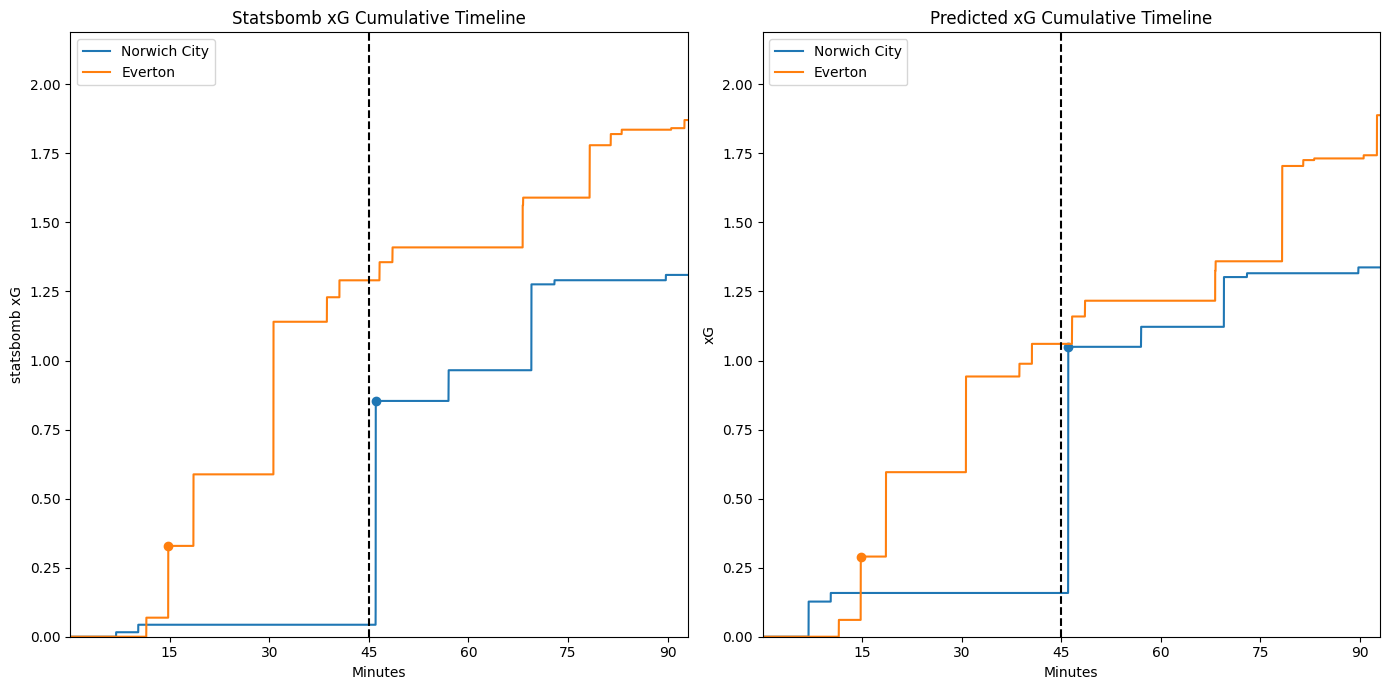

In [28]:
xG_timeline(PL_dt.df)

In [9]:
result = PL.df.filter((F.col('match_id') == 3754050) & (F.col('period') == 1)) \
    .orderBy(['minute', 'second'], ascending=[False, False]) \
    .limit(1) \
    .select('minute', 'second') \
    .collect()[0]

formatted_result = f"{result['minute']}.{result['second']/60 * 100 :.0f}"

print(float(formatted_result) - 45.00)

1.1499999999999986


In [10]:
d = PL.df.filter(F.col('match_id')==3754050).toPandas()

In [11]:
d.loc[d['period'] == 2, 'minute'] += 100
d

,id,player,player_id,match_id,team,period,minute,second,shot_location_x,shot_location_y,...,pass_outswinging,pass_straight,pass_no_touch,shot_outcome,shot_end_location,shot_end_x,shot_end_y,sb_prediction,shot_statsbomb_xg,goal
0,6e0be8fc-6847-4f30-8e24-91caf2456a90,Wahbi Khazri,3196.0,3754050,Sunderland,1,13,49,100.300003,50.599998,...,0,0,0,Blocked,"[106.8, 46.5]",106.8,46.5,0,0.040541,0
1,d64fd9cb-22c3-46c5-a5cd-e23237d54abf,Connor Wickham,20641.0,3754050,Crystal Palace,2,166,22,115.099998,38.000000,...,0,0,0,Goal,"[120.0, 38.0, 1.4]",120.0,38.0,0,0.297662,1
2,2fcd870a-4276-42c8-a12b-c96da2dcd82c,Patrick van Aanholt,3321.0,3754050,Sunderland,2,157,12,98.199997,33.000000,...,0,0,0,Off T,"[120.0, 58.9, 6.0]",120.0,58.9,0,0.038933,0
3,d66ec495-c9e8-445f-8bc3-8fd89b3bdf5e,Jack Rodwell,18751.0,3754050,Sunderland,1,11,42,95.699997,44.000000,...,0,0,0,Saved,"[116.6, 43.1, 1.3]",116.6,43.1,0,0.050020,0
4,9f980628-31da-4084-99f9-ce8d745be189,Dame N''Doye,16295.0,3754050,Sunderland,1,35,10,92.000000,37.900002,...,0,0,0,Goal,"[120.0, 36.9, 0.2]",120.0,36.9,0,0.037939,1
5,39303960-33d5-48d3-8e5a-2ae2a48626d7,Wilfried Zaha,3507.0,3754050,Crystal Palace,1,8,26,104.400002,53.299999,...,0,0,0,Off T,"[120.0, 49.4, 6.3]",120.0,49.4,0,0.029622,0
6,c63d2e41-d00d-40fd-8a6b-9924b3660841,Jordon Mutch,15892.0,3754050,Crystal Palace,1,20,45,113.000000,26.600000,...,0,0,0,Off T,"[120.0, 35.6, 0.2]",120.0,35.6,0,0.076585,0
7,f2aba870-543d-47a7-81df-3a905d209244,Bakary Sako,3469.0,3754050,Crystal Palace,2,190,53,107.800003,30.799999,...,0,0,0,Blocked,"[109.1, 32.8]",109.1,32.8,0,0.081512,0
8,d4232b4a-c823-4c6c-b1fe-d2b75e0ff9be,Dame N''Doye,16295.0,3754050,Sunderland,1,31,39,91.699997,43.000000,...,0,0,0,Saved,"[115.0, 41.8, 0.6]",115.0,41.8,0,0.036552,0
9,07413db0-cde6-408e-96f1-7c64be42dcf7,Fabio Borini,7171.0,3754050,Sunderland,2,189,55,109.699997,61.500000,...,0,0,0,Goal,"[119.9, 37.8, 0.5]",119.9,37.8,0,0.006759,1
